*Дорога туда, естественно, лежала сквозь облака,
напоминавшие цветом то гипс, то мрамор
настолько, что мне показалось, что ты имел в виду
именно это: размытые очертанья,
хаос, развалины мира.*


И. А. Бродский "Я встретил тебя впервые в чужих для тебя широтах..."

# Кластеризация форм рук классификаторных предикатов РЖЯ по векторам существительного-референта и глагола

*Дисклеймер:* простите за длину тетрадки, это всё ко~т~д. На самом деле, можно читать только маркдауновские вставки и решёточные комментарии.

## 0. Введение

Данный мини-проект опирается на материалы моей курсовой, посвященной обзору инвентаря форм рук классификаторных предикатов РЖЯ ([текст курсовой](https://github.com/ancheveleva/rsl_clfs_handshapes/blob/main/Cheveleva_Handshape_Inventory_of_RSL_Classifier_Predicates.pdf) и [презентация с защиты](https://github.com/ancheveleva/rsl_clfs_handshapes/blob/main/Cheveleva_Handshape_Inventory_of_RSL_Classifier_Predicates_pres.pdf)). В рамках неё было выделено 16 конфигураций (включая алломорфы), а также была предложена разметка классификаторов в формате `существительное.референт:№формы.руки:глагол`. И существительное, и глагол устанавливались в соответствии с переводом на (звучащий) русский язык. С помощью подобной разметки можно попытаться ответить на следующий вопрос: возможно ли определить форму руки классификатора по векторным представлениям соответствующих существительного и глагола?

Гипотеза состоит в том, что да, до какой-то степени обобщения форм можно, при этом существительное будет оказывать большее влияние, так как представление референта формы в первую очередь закреплено за ним (тогда как глагол в классификаторе больше ассоциирован с движением).

План мини-проекта:
1. Подготовка моделей и данных
2. Векторизация сущиствительных и глаголов
3. Оценка распределения векторизованных объектов
4. Кластеризация алгоритмом DBSCAN
5. Кластеризация алгоритмом K-means
6. Выводы

## 1. Подготовка моделей и данных

In [273]:
import zipfile
import wget
import gensim
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as hcluster
from pymorphy2 import MorphAnalyzer
import urllib.request
from sklearn.cluster import DBSCAN
from sklearn import manifold
from collections import defaultdict, Counter
from sklearn.cluster import KMeans

Я буду использовать предобученную неконтекстуализированную модель, чтобы рассмотреть влияние каждого из слов по отдельности. Также я возьму модель, в которой сохранены стоп-слова, поскольку в разметке некоторых глаголов присутствуют предлоги (ср. *прыгнуть* и *прыгнуть.на*).

In [3]:
# скачиваем модель (та, в которой есть стоп слова according to https://rusvectores.org/ru/models/)
model_url = 'http://vectors.nlpl.eu/repository/20/183.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

Для того, чтобы передавать слова в модель, необходимо, во-первых, лемматизировать их, и, во-вторых, добавить к ним частеречный тег. Поскольку в разметке в нескольких местах встречаются существительные множественного числа (*люди*) и слова других частей речи, кроме существительного и глагола (прилагательные, предлоги, наречия), то, чтобы автоматизировать данный процесс, будет использоваться морфоанализатор `pymorphy`.

Поскольку тегсеты `pymorphy` и выбранной модели не совпадают, дополнительно конвертируем всё в формат тегсета модели ([Universal Tags](https://universaldependencies.org/u/pos/index.html)).

In [4]:
# морфпарсер
morph = MorphAnalyzer()

# конвертирование тегов
tags = {'NOUN': 'NOUN', 'VERB': 'VERB', 'INFN': 'VERB',
       'ADJF': 'ADJ', 'PREP': 'ADP', 'ADVB': 'ADV', 'COMP': 'ADV'}

Данные представляют собой список уникальных классификаторов вида `существительное.референт:№формы.руки:глагол`. Для удобства разбиваем его на три колонки и ставим в соответсвие более обобщенный список форм, учитывающий некоторые алломорфы (собственно, те самые 16 форм, о которых говорилось в начале).

In [296]:
# чтение файла
with open('clfs_reannotated_unique.txt') as f:
    clfs = f.read().splitlines()
df = pd.DataFrame(clfs, columns=['clf'])

In [297]:
# ставим в соответствие формы
df_shapes = pd.read_excel('clfs_reannotated_summary.xlsx')
df_shapes = df_shapes[['shape (Клезович 2020)', 'shape (в данной работе)']].rename(columns={'shape (Клезович 2020)': 'shape', 'shape (в данной работе)': 'shape_sum'})
df_shapes['shape'] = df_shapes['shape'].astype(str)

shapes_dict = pd.Series(df_shapes['shape_sum'].values, index=df_shapes['shape']).to_dict()

In [298]:
df[['noun','shape', 'verb']] = df.clf.str.split(':',expand=True)
df['shape'] = df['shape'].astype(str).apply(lambda x: shapes_dict[x])
df = df.drop(['clf'], axis=1)
df = df.drop(df[df['shape'] == '-'].index)

In [299]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(152, 3)
(151, 3)


In [300]:
df.head()

,noun,shape,verb
1,волосы,5,торчать
3,вода,5,стекать
4,волосы,500,трогать
5,голова,500,быть
6,волосы,Ф,быть


## 2. Векторизация сущиствительных и глаголов

In [305]:
# получение векторов из модели
def get_vector(word, model=model):
    words = word.split('.')
    words_vectors = []
    for word in words:
        parsed = morph.parse(word)[0]
        lemma = parsed.normal_form.replace('ё', 'е')
        pos = str(parsed.tag).split(',')[0]
        udpos = tags[pos]
        vector = model[f'{lemma}_{udpos}']
        words_vectors.append(vector)
    return sum(words_vectors) # если подтег состоит из нескольких слов, они складываются (ср. прыгнуть.на)

In [306]:
df['noun_vector'] = df.noun.apply(get_vector)
df['verb_vector'] = df.verb.apply(get_vector)

Для начала посмотрим, как вообще зависят друг от друга форма руки и вектора слов. Для упрощения представления на двумерном графике в качестве последнего возьмем число -- скалярное произведение векторов существительного и глагола.

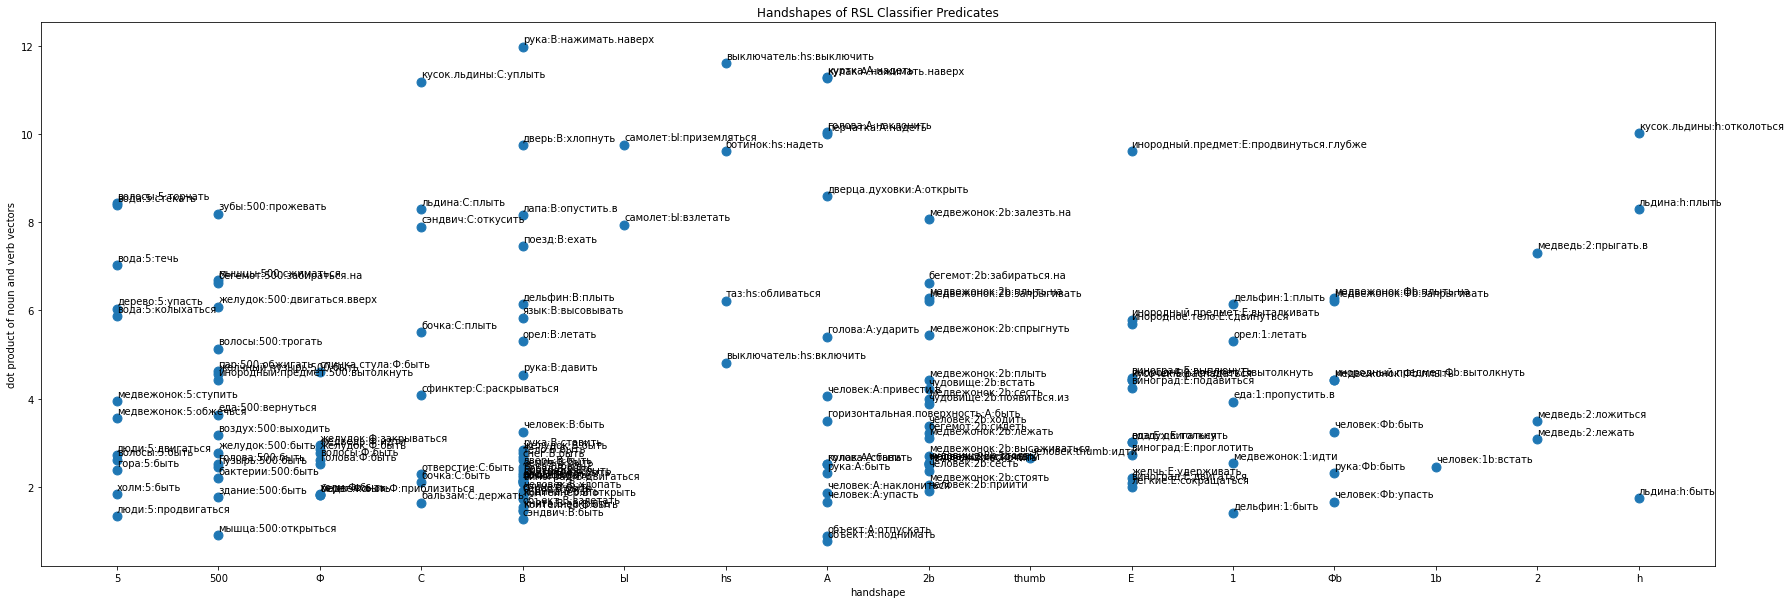

In [307]:
df['n_v_dot'] = df.apply(lambda x: np.dot(x.noun_vector, x.verb_vector), axis=1)

fig, ax = plt.subplots(figsize=(30, 10))
ax.scatter(df['shape'].values, df['n_v_dot'].values, s=80)
ax.set_title('Handshapes of RSL Classifier Predicates')
ax.set_xlabel('handshape')
ax.set_ylabel('dot product of noun and verb vectors')
for i, annot in enumerate(annotations):
    ax.annotate(annot, (df['shape'].values[i], df['n_v_dot'].values[i] + 0.1), fontsize=10)

Видно, что в целом скалярное произведение практически никак не позволяет однозначно определить форму. Однако при крайних значениях разброс потенциальных ответов немного меньше. Также существуют формы, в которых находятся только определенные существительные. Таким образом, чтобы проверить влияние и существительног0, и глагола 
создадим дополнительно вектора их суммы и попарного произведения.

In [308]:
df['n_v_add'] = df.apply(lambda x: np.add(x.noun_vector, x.verb_vector), axis=1)
df['n_v_mult'] = df.apply(lambda x: np.multiply(x.noun_vector, x.verb_vector), axis=1)

In [309]:
df.head()

,noun,shape,verb,noun_vector,verb_vector,n_v_add,n_v_mult,n_v_dot
1,волосы,5,торчать,"[-0.61722296, -0.21646062, -0.043852057, 0.225...","[-0.34271136, -0.03677839, 0.19606423, -0.0364...","[-0.95993435, -0.253239, 0.15221217, 0.1893577...","[0.21152931, 0.007961073, -0.00859782, -0.0082...",8.432854
3,вода,5,стекать,"[-0.17692752, -0.63558596, 0.21185967, -0.2368...","[-0.26958627, -0.047467925, 0.13944441, 0.2922...","[-0.44651377, -0.6830539, 0.35130408, 0.055411...","[0.04769723, 0.030169947, 0.029542647, -0.0692...",8.380983
4,волосы,500,трогать,"[-0.61722296, -0.21646062, -0.043852057, 0.225...","[-0.2951331, 0.06494828, -0.02644503, 0.057571...","[-0.9123561, -0.15151232, -0.070297085, 0.2833...","[0.18216294, -0.0140587455, 0.0011596689, 0.01...",5.130329
5,голова,500,быть,"[-0.20622618, -0.31024337, 0.06593055, -0.1135...","[-0.26926243, 0.012643397, -0.13179517, 0.0219...","[-0.4754886, -0.29759997, -0.065864615, -0.091...","[0.055528965, -0.00392253, -0.008689328, -0.00...",2.516087
6,волосы,Ф,быть,"[-0.61722296, -0.21646062, -0.043852057, 0.225...","[-0.26926243, 0.012643397, -0.13179517, 0.0219...","[-0.8864854, -0.20381722, -0.17564723, 0.24774...","[0.16619496, -0.0027367976, 0.0057794894, 0.00...",2.619468


## 3. Оценка распределения векторизованных объектов

Стоит оговориться, что размер классов в моей выборке не сбаллансирован, но от этого эффекта никак не избавиться, поскольку некоторые формы рук и правда являются более базовыми и сочетаются с большим числом глаголом (а значит, входят в мой набор уникальных классификаторов как разные вхождения).

In [310]:
df['shape'].value_counts()

В        32
2b       20
500      16
А        15
Е        13
5        12
Ф         9
С         8
Фb        7
1         5
hs        4
2         3
h         3
Ы         2
thumb     1
1b        1
Name: shape, dtype: int64

Тем не менее, если раскрасить объекты по форме руки и изобразить в сжатом пространстве, то получаются следующие графики.

In [347]:
# цвета и подписи к графикам
rgb = [np.random.rand(3) for i in range(16)]
color_shape = dict(zip(set(df['shape'].values), rgb))
colors = [color_shape[shape] for shape in df['shape'].values]
annotations = list(df.apply(lambda x: ':'.join([x['noun'], x['shape'], x['verb']]), axis=1))

In [348]:
def draw_scatter(column, annotate=True, size=80):
    # данные
    arr = df[column].to_numpy()
    X = np.array([x for x in arr])

    # сжатие размерности
    mds = manifold.MDS(n_components=2)
    array_mds = mds.fit_transform(X)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(array_mds[:, 0], array_mds[:, 1], c=colors, s=size)
    ax.set_title(column)
    if annotate:
        for i, annot in enumerate(annotations):
            ax.annotate(annot, (array_mds[i, 0], array_mds[i, 1] + 0.1), fontsize=10)

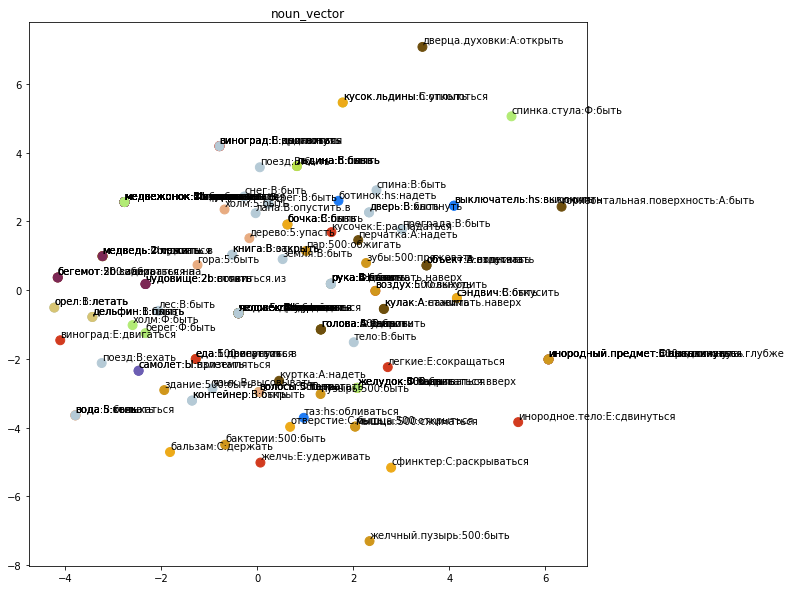

In [349]:
# для вектора существительного
draw_scatter('noun_vector')

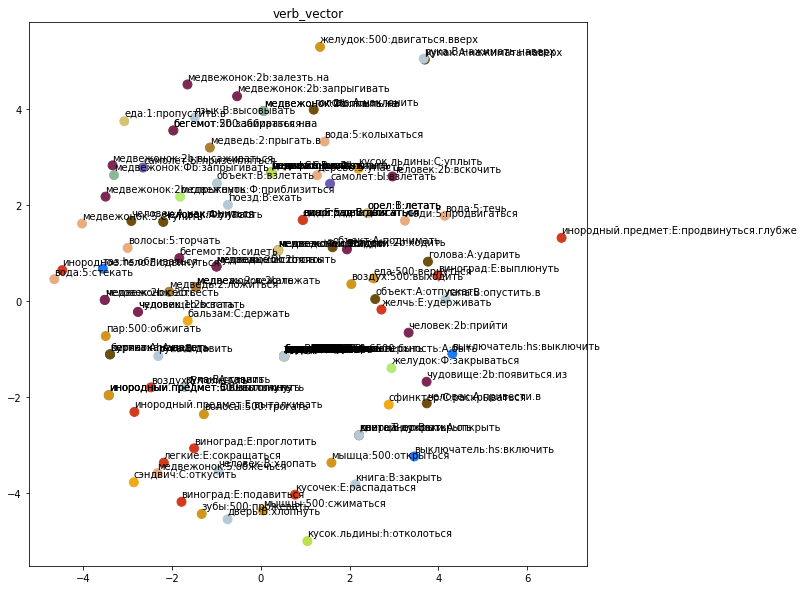

In [350]:
# для вектора глагола
draw_scatter('verb_vector')

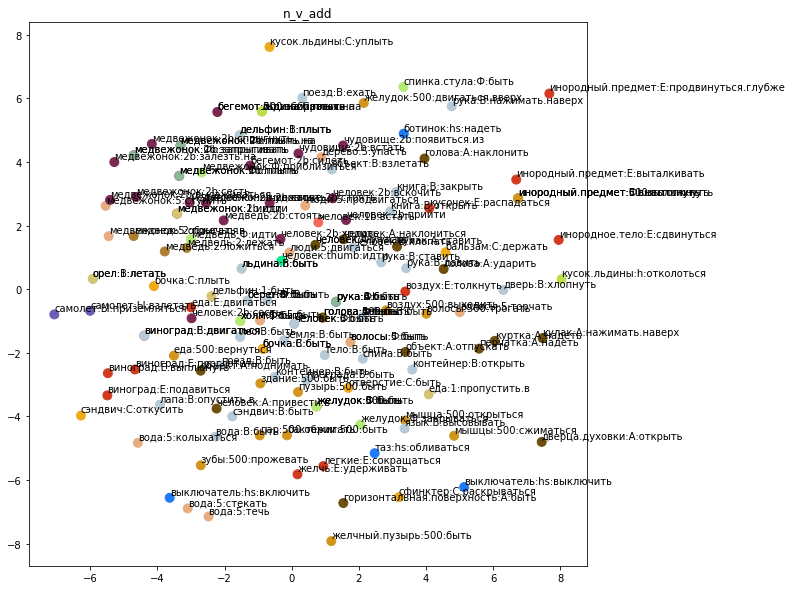

In [351]:
# для аддитивного вектора
draw_scatter('n_v_add')

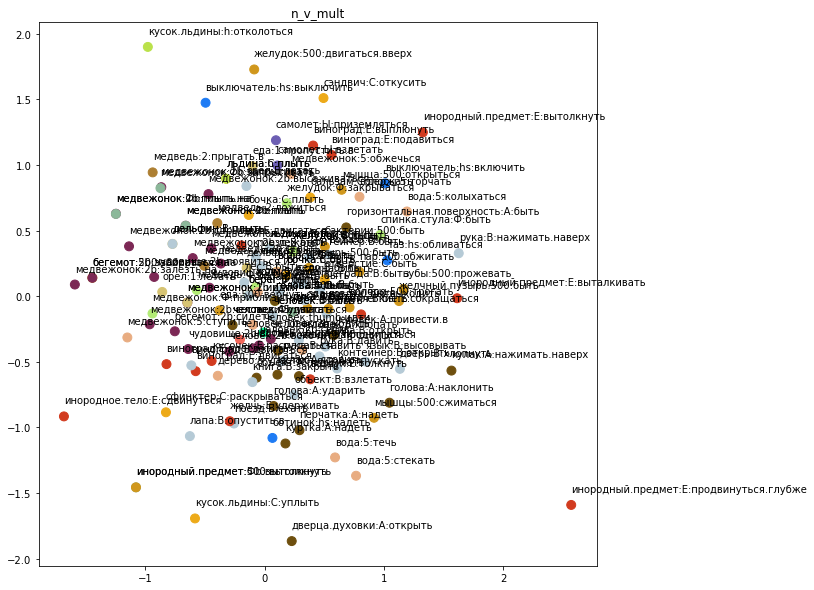

In [354]:
# для мультипликативного вектора
draw_scatter('n_v_mult')

Представим все 4 варианта на одном рисунке, но без подписей (для большей наглядности). Разные цвета всё так же соответствуют разным формам.

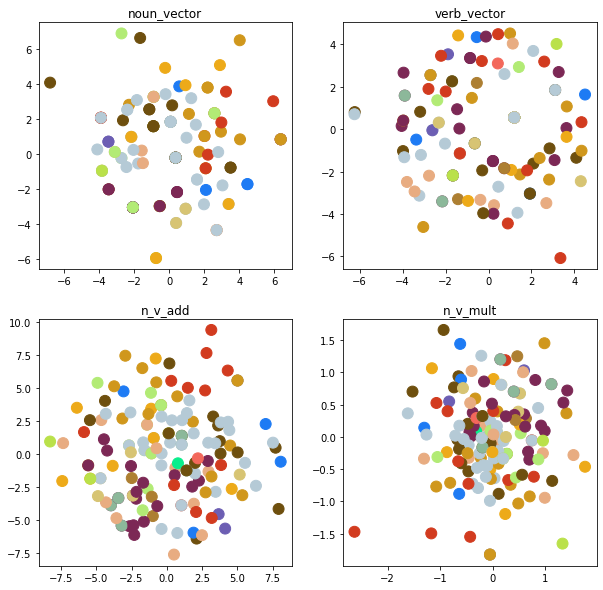

In [353]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, column in enumerate(['noun_vector', 'verb_vector', 'n_v_add', 'n_v_mult']):
    # данные
    arr = df[column].to_numpy()
    X = np.array([x for x in arr])

    # сжатие размерности
    mds = manifold.MDS(n_components=2)
    array_mds = mds.fit_transform(X)

    axes[i//2, i%2].scatter(array_mds[:, 0], array_mds[:, 1], c=colors, s=120)
    axes[i//2, i%2].set_title(column)

Видим, что всё в целом довольно ~облачно~ туманно. При этом изначальная гипотеза, как кажется, не оправдалась: существительные группируются ничуть не лучше остальных типов векторов. При этом наиболее разумным, на мой взгляд, является распределение аддитивных векторов: объекты не слишком сильны прижаты друг к другу, как в мультипликативных векторах, и при этом даже как будто выделяются какие-то зоны (например, баклажановые объекты скорее слева снизу). В дальнейших экспериментах я буду использовать аддитивные вектора.

## 4. Кластеризация алгоритмом DBSCAN

Гиперпараметры в алгоритме DBSCAN:
* eps -- размер окресности, в рамках которой будем считать, что объекты принадлежат к одному классу
* min_samples -- минимальное число объектов в окрестности (классе). По умолчанию == 5, однако, как видно выше, среди наших объектов 6 из 16 таргетных классов имеют меньший размер. Уменьшение данного параметра может привести к переобучению модели. В связи с этим попробуем подобрать оптимальный размер класса.

In [355]:
# данные
arr = df['n_v_add'].to_numpy()
X = np.array([x for x in arr])

for samples in [2, 3, 4, 6, 8, 10]:
    for e in [0.05, 0.2, 1, 3, 5]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)
        print(f'eps={e}, min_samples={samples}')
        print('Число кластеров:', len(set(clusters)), end='\n\n')

eps=0.05, min_samples=2
Число кластеров: 21

eps=0.2, min_samples=2
Число кластеров: 21

eps=1, min_samples=2
Число кластеров: 21

eps=3, min_samples=2
Число кластеров: 22

eps=5, min_samples=2
Число кластеров: 10

eps=0.05, min_samples=3
Число кластеров: 5

eps=0.2, min_samples=3
Число кластеров: 5

eps=1, min_samples=3
Число кластеров: 5

eps=3, min_samples=3
Число кластеров: 8

eps=5, min_samples=3
Число кластеров: 6

eps=0.05, min_samples=4
Число кластеров: 1

eps=0.2, min_samples=4
Число кластеров: 1

eps=1, min_samples=4
Число кластеров: 1

eps=3, min_samples=4
Число кластеров: 2

eps=5, min_samples=4
Число кластеров: 4

eps=0.05, min_samples=6
Число кластеров: 1

eps=0.2, min_samples=6
Число кластеров: 1

eps=1, min_samples=6
Число кластеров: 1

eps=3, min_samples=6
Число кластеров: 1

eps=5, min_samples=6
Число кластеров: 2

eps=0.05, min_samples=8
Число кластеров: 1

eps=0.2, min_samples=8
Число кластеров: 1

eps=1, min_samples=8
Число кластеров: 1

eps=3, min_samples=8
Число 

Наиболее похожим по числу на таргетные 16 классов выглядит распределение на 10 классов при параметрах `eps=5, min_samples=2`. При другим параметров наблюдаем либо переразличение объектов, либо переобобщение до одного-двух классов.

In [356]:
dbscan = DBSCAN(eps=5, min_samples=2)
dbscan_clusters = dbscan.fit_predict(X)

In [357]:
dbscan_dict = defaultdict(list)
for i, clus in enumerate(dbscan_clusters):
    dbscan_dict[clus].append(annotations[i])
dbscan_dict

defaultdict(list,
            {0: ['волосы:5:торчать',
              'волосы:500:трогать',
              'голова:500:быть',
              'волосы:Ф:быть',
              'голова:Ф:быть',
              'волосы:5:быть',
              'люди:5:продвигаться',
              'люди:5:двигаться',
              'поезд:В:ехать',
              'человек:2b:вскочить',
              'человек:thumb:идти',
              'здание:500:быть',
              'человек:2b:прийти',
              'человек:2b:сесть',
              'человек:2b:ходить',
              'человек:А:привести.в',
              'книга:В:открыть',
              'книга:В:закрыть',
              'земля:В:быть',
              'дверь:В:быть',
              'дерево:5:упасть',
              'поезд:В:быть',
              'рука:В:быть',
              'контейнер:В:открыть',
              'виноград:Е:проглотить',
              'отверстие:С:быть',
              'виноград:Е:подавиться',
              'виноград:Е:выплюнуть',
              'виноград:Е:дв

Посмотрим на получившиеся классы:
* 0 -- всё подряд
* 1 -- про существиельное *вода* + форма? (для *воды* вариативность небольшая)
* -1 -- чуть меньше всё подряд
* 2 -- про глаголы вертикального перемещения (*взлетать, приземляться, отпускать, поднимать*)?
* 3 -- *выключатель*
* 4 -- предметы одежды + *надеть*
* 5 -- *воздух*
* 6 -- *инородный предмет* + *вытолкнуть*
* 7 -- *кулак/рука* + *нажимать.вверх*
* 8 -- *орел* + *летать*

Видно, что при распределении на классы учитывались не те семантические характеристики, которые мы бы ожидали для классификаторов (в первую очередь -- размер и форма), а объединение либо в целом по одному существительному/глаголу, либо по гиперонимам или синонимам. В рамках классов существуют классификаторы с очень различающимися формами рук, никак не свожимых друг к другу (например, В и 1 в 8, или 2b и А в 0).

## 5.  Кластеризация алгоритмом K-means

Поскольку в данном алгоритме, в отличие от предыдущего, необходимо самому подбирать число классов, заданим наше целевое 16.

In [358]:
kmeans_clusters = KMeans(n_clusters=16).fit_predict(X)
kmeans_dict = defaultdict(list)
for i, clus in enumerate(kmeans_clusters):
    kmeans_dict[clus].append(annotations[i])
kmeans_dict

defaultdict(list,
            {8: ['волосы:5:торчать',
              'волосы:500:трогать',
              'голова:500:быть',
              'волосы:Ф:быть',
              'голова:Ф:быть',
              'волосы:5:быть',
              'бальзам:С:держать',
              'пар:500:обжигать',
              'куртка:А:надеть',
              'ботинок:hs:надеть',
              'перчатка:А:надеть',
              'дверь:В:быть',
              'рука:В:быть',
              'воздух:Е:толкнуть',
              'кулак:А:ставить',
              'голова:А:быть',
              'воздух:500:выходить',
              'рука:А:быть',
              'рука:Фb:быть',
              'рука:В:давить',
              'рука:В:ставить',
              'спинка.стула:Ф:быть',
              'лапа:В:опустить.в',
              'язык:В:высовывать'],
             5: ['вода:5:стекать',
              'вода:5:течь',
              'вода:5:колыхаться',
              'вода:В:быть'],
             11: ['люди:5:продвигаться',
              'л

Видим, что в целом кластеры не отличаются от тех, что получились при DBSCAN:
* тоже вертикальное перемещение, тоже *выключатель*, тоже *инородный предмет*
* \+ кластер частей и огранов тела
* \+ звери вместе, хотя медвежонок отдельно
* \+ про *плавать*
* \+ про *быть*

В классах всё также смешаны разные формы.

## 6. Выводы

Кластеризовать классификаторы в соответствии с формой руки по векторам существительного и/или глагола не получилось.

Из наиболее явных и важных причин мне видятся дисбаланс классов и модальность, и если первую проблему еще можно попробовать решить объединением более мелких классов/разбиением более крупных, то что делать со второй, не очень понятно. Возможно, что те семантические особенности слов, которые улавливает векторная модель русского (звучащего) языка, нерелеватны для РЖЯ, или релевантны, но в другой степени, а какие-то другие характеристики, связанные с визуальной модальностью, не учитываются вовсе. Так что, на мой взгляд, дальнейшая работа состоит либо в анализе непосредственно видео, без промежуточного этапа письменных глосс, либо в доразметке данных в рамках предложенного мной подхода и поиске возможных ошибок в проделанной работе. 